In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn import Module, Sequential, Linear, Conv2d, ReLU, Tanh
from torch.utils.data import DataLoader

from torchvision.transforms import transforms
import torchvision.datasets as datasets

from torch.distributions.multivariate_normal import MultivariateNormal

from models import U_Net

In [2]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(device)

cuda


In [3]:
batch_size = 1   #len: 5918
num_samples_train = 1000 #batch_size
input_shape = (batch_size, 2, 32, 32)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

train_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=True,
    transform=transform,
)

train_dataset.data = train_dataset.data[train_dataset.targets == 6]
train_dataset.targets = train_dataset.targets[train_dataset.targets == 6]

test_dataset = datasets.MNIST(
    "./data/MNIST",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [4]:
train_dataset_target = 0 #len: 5918
for img in train_dataloader:
    train_dataset_target = img[0].to(device)
    break
print(train_dataset_target.shape)
train_dataset_target = train_dataset_target.repeat(num_samples_train, 1, 1,1)

torch.Size([1, 1, 32, 32])


In [5]:
print(train_dataset_target.shape)

torch.Size([1000, 1, 32, 32])


In [6]:
normal_init = MultivariateNormal(torch.tensor([[0 for i in range(32*32)]]).float(), 0.15*torch.stack([torch.eye(32*32) for i in range(1)]))
train_dataset_init=(normal_init.sample([num_samples_train]).to(device).reshape(-1, 1, 32,32))

In [7]:
print(train_dataset_init.shape)

torch.Size([1000, 1, 32, 32])


In [8]:
pairs_1 = torch.stack([train_dataset_init, train_dataset_target], axis=1)

In [9]:
print(pairs_1.shape)
indeces = torch.randperm(num_samples_train)
batch = pairs_1[indeces]
batch_init = batch[:, 0]
batch_target = batch[:, 1]
print(batch_init.shape)

torch.Size([1000, 2, 1, 32, 32])
torch.Size([1000, 1, 32, 32])


Text(0.5, 1.0, 'distribution of pixels')

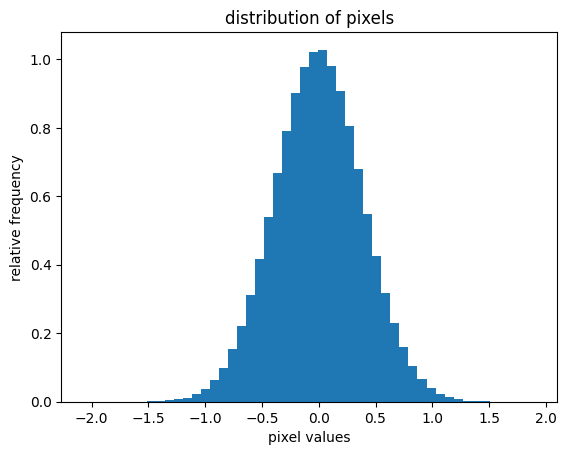

In [10]:
# plot the pixel values
plt.hist(train_dataset_init.cpu().numpy().ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels")

tensor(-0.7307)
tensor(0.5814)
tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.7020,  0.6000,
         0.9529,  0.3725, -0.5765, -0.9765, -1.0000, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9843,
        -0.9294, -0.9294, -0.9765, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000])


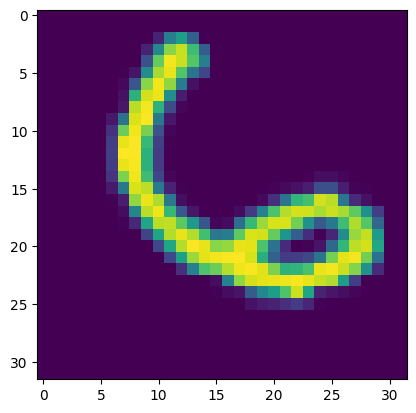

In [11]:
for i, j in train_dataloader:
    print(torch.mean(i))
    print(torch.std(i))
    print(i[0][0][14])
    plt.imshow(i[0][0].cpu().numpy())
    break

In [12]:
class v_model(Module):
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape

        self.NN = U_Net(input_shape=input_shape, output_channels=1, initial_lr="", momentum="", weight_decay="")

    def forward(self, x_input, t):
        t = torch.ones_like(x_input) * t
        inputs = torch.stack([x_input, t], dim=2).reshape((x_input.shape[0], 2, 32,32 ))
        x = self.NN(inputs)

        return x

In [13]:
class RectifiedFlow(Module):
    def __init__(self, v_model):
        super().__init__()
        self.v_model = v_model.to(device)
        self.loss_curve = []

    def get_train_tuple(self, z0, z1):
        # random times
        t = torch.rand((z0.shape[0], 1)).to(device)
        t = t[:,:,None, None]
        # linear interpolation
        z_t = t* z1 + (1-t) * z0
        # connection line
        target = z1 - z0

        return z_t, t, target


    def sample_ode(self, z0, num_steps):
        trajectory = []
        trajectory.append(z0.detach().clone())

        batchsize = z0.shape[0]

        dt = 1./num_steps
        z = z0.detach().clone()
        for i in range(num_steps):
            t = torch.ones((batchsize, 1)).to(device) * i /num_steps
            t = t[:,:,None, None]
            #print(t.shape)
            pred = self.v_model(z, t)
            z = z.detach().clone() + pred * dt

            trajectory.append(z.detach().clone())

        return trajectory

In [14]:
def train_rectified_flow(rectified_flow, optimizer, pairs, iterations, batchsize=128):
    loss_curve = rectified_flow.loss_curve
    for iteration in range(iterations):
        torch.cuda.empty_cache()
        
        indeces = torch.randperm(num_samples_train)
        batch = pairs[indeces][:batchsize]
        batch_init = batch[:, 0]
        batch_target = batch[:, 1]

        z_t, t, target = rectified_flow.get_train_tuple(batch_init, batch_target)
        # print("z_t: ",z_t)
        # print("t: ",t)
        # print("target: ", target[0][0])
        # print("target2: ", target[0][0][0])
        # print("target3: ", target[0][0][14])
        # plt.imshow(target[0][0].reshape(32,32).cpu().numpy())
        # plt.show()

        pred = rectified_flow.v_model(z_t, t)
        # print("pred: ", pred[0])
        # print(pred[0][0][14])
        # plt.imshow(pred[0][0].reshape(32,32).detach().cpu().numpy())
        # plt.show()
        loss = (target - pred).view(pred.shape[0], -1).abs().pow(2).sum(dim=1)
        # print("loss: ", (target - pred).view(pred.shape[0], -1).abs().pow(2)[14])
        # plt.imshow((target - pred)[0,0].detach().cpu().numpy())
        # plt.show()
        loss = loss.mean()
        if iteration % 100 == 0:
            print(f"iteration: {iteration}, loss: {loss}")
        loss.backward()

        optimizer.step()
        loss_curve.append(loss.item())

    rectified_flow.loss_curve = loss_curve
    return rectified_flow, loss_curve

In [9]:
v_mod = v_model(input_shape)
rectified_flow_1 = RectifiedFlow(v_mod)

In [15]:
rectified_flow_1 = torch.load("./models/MNIST_test5_2.pth")

iteration: 0, loss: 246.3258056640625
iteration: 100, loss: 130.95391845703125
iteration: 200, loss: 100.73534393310547
iteration: 300, loss: 88.37906646728516
iteration: 400, loss: 76.49020385742188
iteration: 500, loss: 80.94544219970703
iteration: 600, loss: 85.19644165039062
iteration: 700, loss: 81.39094543457031
iteration: 800, loss: 77.61687469482422
iteration: 900, loss: 72.73822021484375


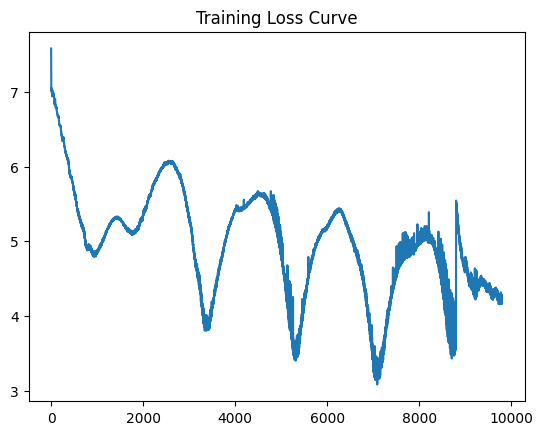

In [32]:
optimizer = torch.optim.Adam(rectified_flow_1.v_model.parameters(), lr=5e-4) #try SGD

rectified_flow_1, loss_curve_1 = train_rectified_flow(rectified_flow_1, optimizer, pairs_1, iterations=1000)
torch.save(rectified_flow_1, "./models/MNIST_test5_2.pth")
#rectified_flow_1_load = torch.load("./models/MNIST_test5_2.pth")
plt.plot(np.log(loss_curve_1))
plt.title("Training Loss Curve")
plt.show()

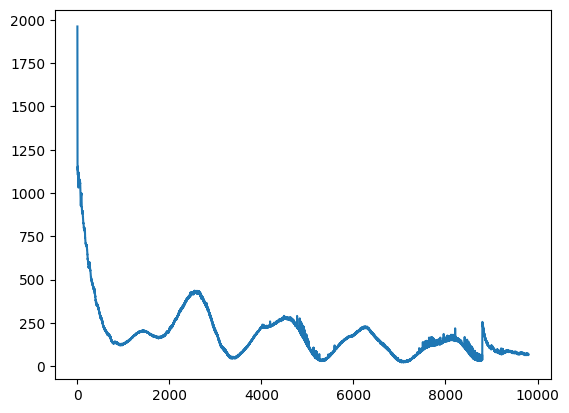

In [16]:
plt.plot(rectified_flow_1.loss_curve)

In [21]:
print(rectified_flow_1.loss_curve.__len__())

6000


In [9]:
rectified_flow_1 = torch.load("./models/MNIST_test5_2.pth")

In [17]:
torch.cuda.empty_cache()
curr_img = 0
#print(batch_init.shape)
img = rectified_flow_1.sample_ode(pairs_1[:10, 0], 100)
print(torch.mean(pairs_1[curr_img, 0]))
print(torch.mean(pairs_1[curr_img, 1]))
print(torch.mean(img[-1][curr_img]))
plt.imshow(pairs_1[curr_img, 0].reshape(32,32).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(32,32).detach().cpu().numpy())
print(img[-1][curr_img].reshape(32,32))
plt.show()
plt.imshow(pairs_1[curr_img, 1].reshape(32,32).detach().cpu().numpy())
print(pairs_1[curr_img, 1].reshape(32,32))
plt.show()

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 7.79 GiB total capacity; 1.46 GiB already allocated; 25.19 MiB free; 1.50 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
#del train_dataset_target
torch.cuda.empty_cache()
v_mod_2 = v_model(input_shape)
rectified_flow_2 = RectifiedFlow(v_mod_2)
torch.cuda.empty_cache()
flow_1 = rectified_flow_1.sample_ode(train_dataset_init, 100)
#pairs_2 = torch.stack([train_dataset_init, flow_1[:][-1]], axis=1)

RuntimeError: CUDA out of memory. Tried to allocate 126.00 MiB (GPU 0; 7.79 GiB total capacity; 6.23 GiB already allocated; 53.25 MiB free; 6.47 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

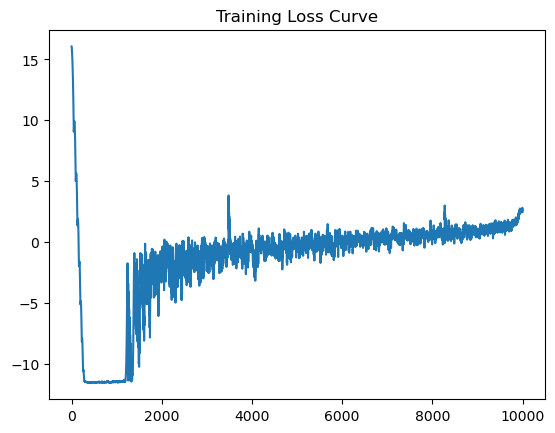

In [ ]:
optimizer = torch.optim.Adam(rectified_flow_2.v_model.parameters(), lr=5e-3)

rectified_flow_2, loss_curve_2 = train_rectified_flow(rectified_flow_2, optimizer, pairs_2, iterations = 1000)
plt.plot(np.log(loss_curve_2))
plt.title("Training Loss Curve")
plt.show()

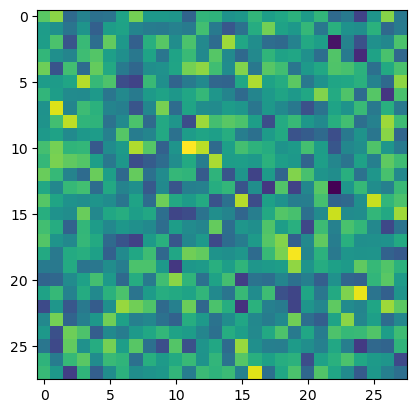

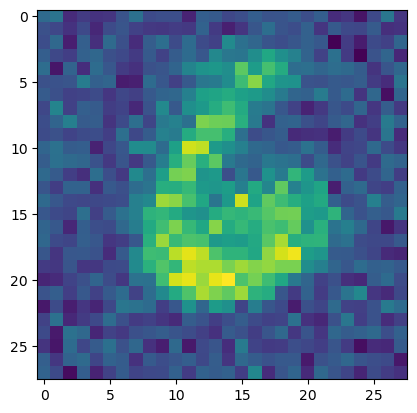

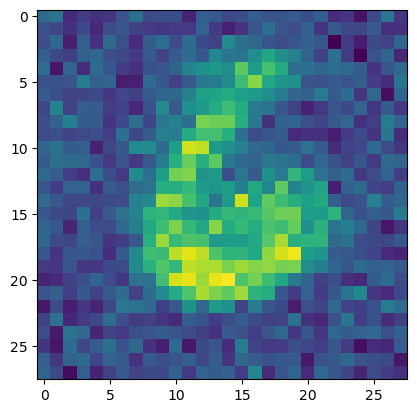

In [ ]:
curr_img = 0
img = rectified_flow_2.sample_ode(pairs_1[:100][0], 1)
plt.imshow(pairs_2[curr_img][0].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(pairs_2[curr_img][1].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[-1][curr_img].reshape(28,28).detach().cpu().numpy())

plt.show()

In [ ]:
del v_mod
torch.cuda.empty_cache()
v_mod_3 = v_model(input_dim, 784)
rectified_flow_3 = RectifiedFlow(v_mod_3)
flow_2 = rectified_flow_2.sample_ode(train_dataset_init, 100)
pairs_3 = torch.stack([train_dataset_init, flow_2[:][-1]], axis=1)

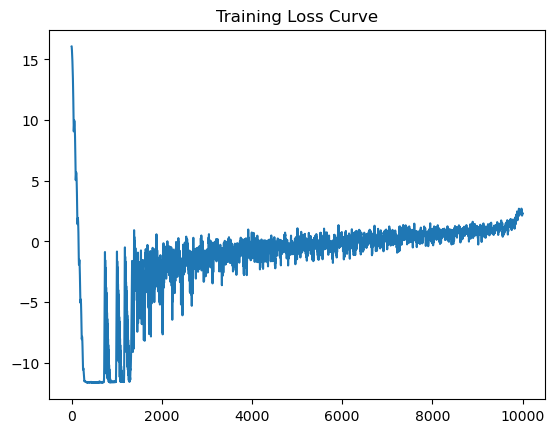

In [ ]:
optimizer = torch.optim.Adam(rectified_flow_3.v_model.parameters(), lr=5e-3)

rectified_flow_3, loss_curve_3 = train_rectified_flow(rectified_flow_3, optimizer, pairs_3, batch_size, inner_iters)
plt.plot(np.log(loss_curve_3))
plt.title("Training Loss Curve")
plt.show()

torch.Size([100, 784])


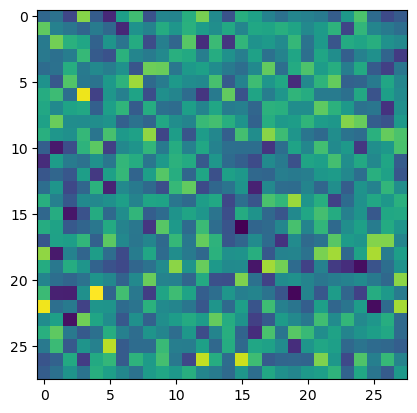

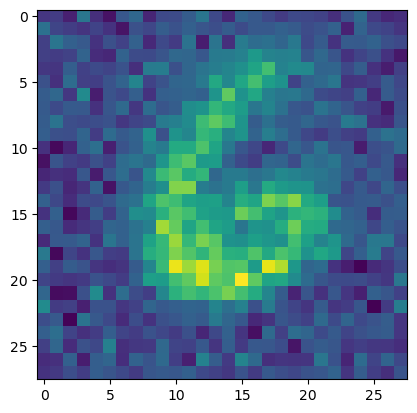

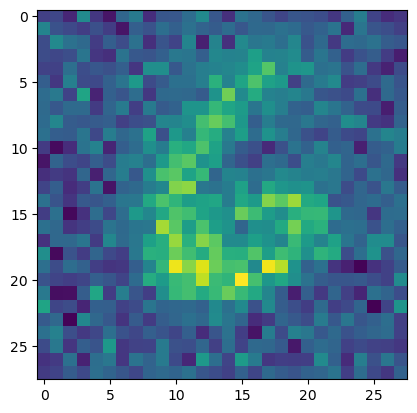

In [ ]:
curr_img = 30
img = rectified_flow_3.sample_ode(train_dataset_init[:100], 100)
print(img[-1].shape)
plt.imshow(train_dataset_init[curr_img].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(pairs_3[curr_img][1].reshape(28,28).detach().cpu().numpy())
plt.show()
plt.imshow(img[70][curr_img].reshape(28,28).detach().cpu().numpy())

plt.show()